In [1]:
import sys, os
os.environ["THEANO_FLAGS"] = "device=cuda"  # use gpu
sys.path.append("../../../")
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\__init__.py", line 227, in <module>
    use(config.device)
  File "C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\gpuarray\__init__.py", line 99, in init_dev
    **args)
  File "pygpu\gpuarray.pyx", line 658, in pygpu.gpuarray.init
  Fil

Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  2
Compilation Done!


C:\Users\r02as18\miniconda3\envs\topology\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=2.46756e-12): result may not be accurate.
  rval = scipy.linalg.solve(A, b)


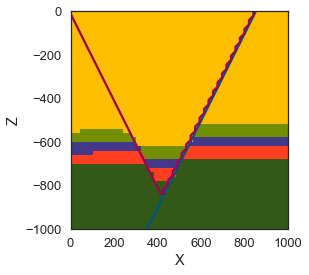

In [2]:
geo_model = gp.load_model(
    'Tutorial_ch1-9b_Fault_relations', 
    path= '../../data/gempy_models', 
    recompile=True
)
gp.compute_model(geo_model)
gp.plot.plot_section(geo_model, show_data=True)

In [365]:
res = geo_model.grid.regular_grid.resolution
lb = np.round(geo_model.solutions.block_matrix[-1, 0, :]).astype(int)
fb = np.round(geo_model.solutions.block_matrix[:-1, 0, :]).astype(int)

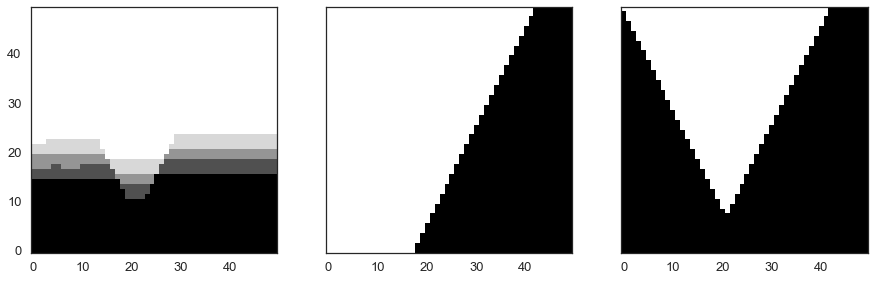

In [267]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15,8))

for ax, block in zip(axs, (lb, *fb)):
    ax.imshow(block.reshape(*res)[:, 24, :].T, origin="lower")

In [257]:
np.unique(lb)

array([3, 4, 5, 6, 7])

In [258]:
for fblock in fb:
    print(np.unique(fblock))

[1 2]
[2 3]


In [44]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
7,fault2,fault_series2,1,False,#015482,1
5,fault1,fault_series1,1,False,#9f0052,2
6,rock4,series1,1,False,#ffbe00,3
0,rock3,series1,2,False,#728f02,4
3,rock2,series1,3,False,#443988,5
1,rock1,series1,4,False,#ff3f20,6
4,basement,basement_series,1,True,#325916,7


In [45]:
geo_model.faults

,isFault,isFinite
fault_series2,True,False
fault_series1,True,False
series1,False,False
basement_series,False,False


### create unique labels

In [259]:
base = 2

n_horizons = len(np.unique(lb))

horizon_ids = []
for i in range(n_horizons):
    horizon_ids.append(base**i)
horizon_ids

lb_labels = np.zeros_like(lb)
for lith_i, i in zip(np.unique(lb), horizon_ids):
    lb_labels[lb == lith_i] = i
lb_labels

# print(np.unique(lb_labels))

fb_labels = np.zeros_like(fb)
for i in range(fb.shape[0]):
    fblock = fb[i]
    fb_max = np.max(fblock)
    fb_labels[i, fblock==fb_max] = base**(i + n_horizons)
    
# print(np.unique(fb_labels))

labels = np.concatenate((fb_labels, lb_labels[None, :]))
labels_sum = np.sum(labels, axis=0)


In [260]:
print(np.unique(lb_labels))

[ 1  2  4  8 16]


In [216]:
labels = np.concatenate((fb_labels, lb_labels[None, :]))
labels = np.sum(labels, axis=0)

### numpy

In [376]:
# faults
fb_01 = fb - fb.min(axis=1)[None, :].T
fault_shift = np.array(range(fb.shape[0]))[:, None] + 1
fb_labels = fb_01 * fault_shift 
fb_labels[fb_labels!=0] += len(np.unique(lb))
# lith
lb_labels = lb - lb.min()
labels = np.concatenate((fb_labels, lb_labels[None, :]))
labels = 22*np.sum(labels, axis=0)

In [377]:
labels

array([242, 242, 242, ..., 286, 286, 286])

### plot unique labels

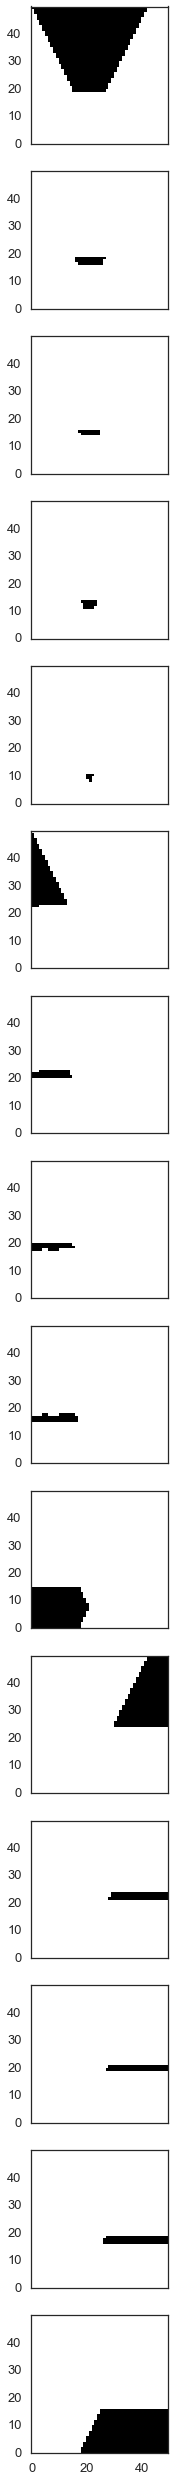

In [379]:
n = len(np.unique(labels))
fig, axs = plt.subplots(nrows=n, figsize=(3, 3*n), sharex=True)

for ax, label in zip(axs, np.unique(labels)):
    pltblock = np.zeros_like(labels)
    pltblock[labels==label] = 1
    ax.imshow(pltblock.reshape(*res)[:, 24, :].T, origin="lower")

### shift labels

In [219]:
labels.shape

(50, 50, 50)

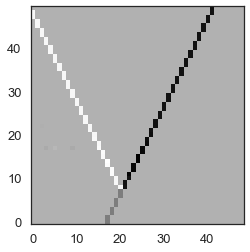

In [380]:
diff1 = labels_sum[1:, :, :] - labels_sum[:-1, :, :]
plt.imshow(diff1[:, 24, :].T, origin="lower")

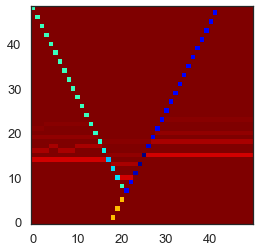

In [381]:
diff2 = labels_sum[:, :, 1:] - labels_sum[:, :, :-1]
plt.imshow(diff2[:, 24, :].T, origin="lower", cmap="jet")